# Reinforcement Learning Environment for ALM

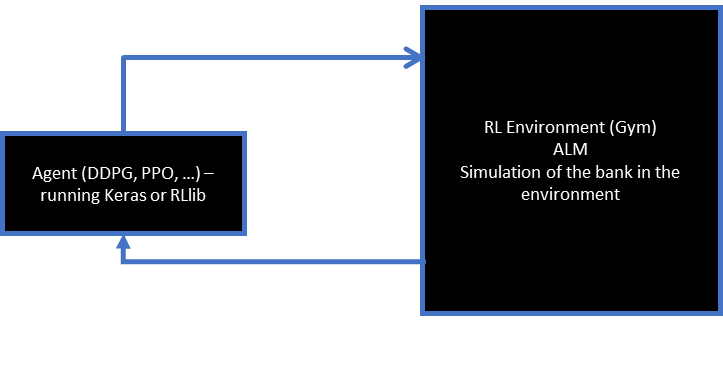


### Simulating a mortgage portfolio

Mortgages typically have a lineair interest rate model - where the monthly prepayment is fixed, or use an annualized schema - in which interest plus prepayment makes a fixed amount per month. To start, we model all mortgages with the lineair interest rate model.

See also: https://riskatwork.nl/wp-content/uploads/2019/11/RAW-MortgagePrepayments.pdf

Customers normally have the option to re-pay the mortgage earlier then the maturity / repricing data.  In general a bank loan may not be held until maturity because:
* Customers repay the loan early (as a percentage of the loan, or fully when moving)
* Customers can default on the loan - forcing the bank to write off the loan

Growth and new business 
Customers can choose the fixed interest period they select. Their choice will be influenced by market expectations, and the rates offered by the bank. 

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
from dateutil.parser import parse

from src.models.bank_model import Bankmodel
from src.data.zerocurve import Zerocurve
from src.data.interest import Interest


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Create interest rates and zero curves

In [14]:
# Create data objects
zerocurve = Zerocurve()
interest = Interest()

Read data from the ECB Statistical Data Warehouse

In [15]:
# Get zero curve historic rates
zerocurve.read_data()
# Get mortgage historic rates
interest.read_data()

2023-04-17 21:05:36.036 | INFO     | src.data.dataset:read_data:26 - reading zerocurve data from ESW.
2023-04-17 21:05:36.990 | INFO     | src.data.dataset:read_data:26 - reading interest data from ESW.


<Response [200]>

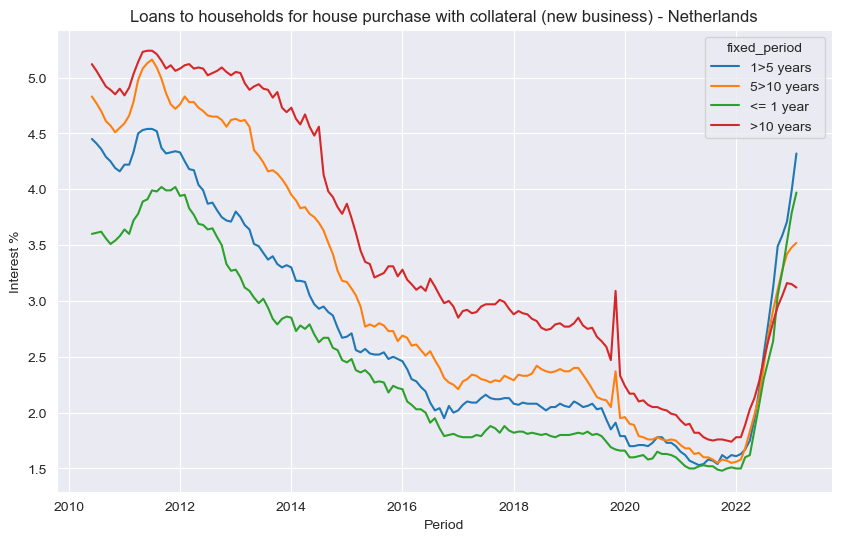

In [16]:
interest.lineplot()

In [17]:
zerocurve.save_data()
interest.save_data()

2023-04-17 21:05:42.472 | INFO     | src.data.dataset:save_data:55 - saving zerocurve data to file.
2023-04-17 21:05:42.880 | INFO     | src.data.dataset:save_data:55 - saving interest data to file.


In [18]:
# Load data from csv file - not directly from ECB
zerocurve.load_data()
interest.load_data()

2023-04-17 21:05:44.898 | INFO     | src.data.dataset:load_data:45 - loading zerocurve data from file.
2023-04-17 21:05:45.162 | INFO     | src.data.dataset:load_data:45 - loading interest data from file.


Generate a Bank model

In [19]:
pos_date = zerocurve.df.index[-1]
bankmodel = Bankmodel(pos_date )

Generate Mortgage contracts

2023-04-17 21:05:49.745 | INFO     | src.models.bank_model:generate_mortgage_contracts:136 - Added 100 mortgages to our portfolio.
2023-04-17 21:05:51.855 | INFO     | src.models.bank_model:generate_mortgage_contracts:140 - Added 18436 cashflows to our model.


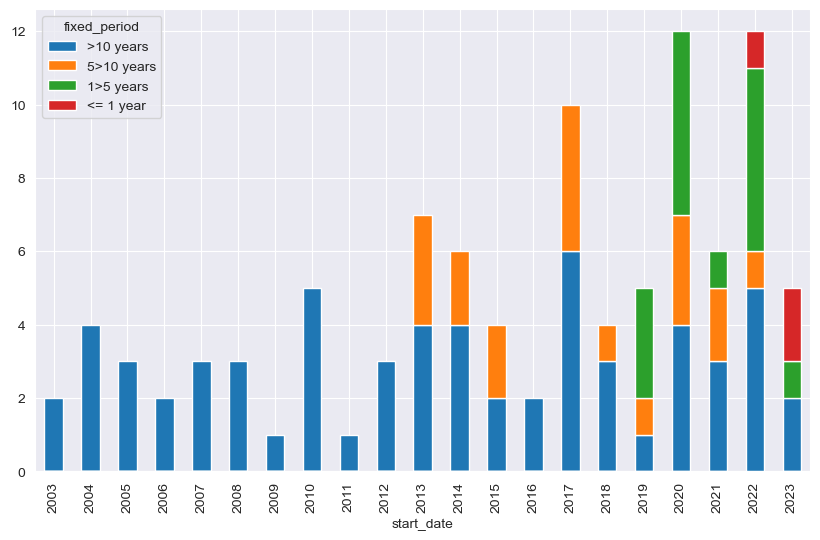

In [20]:

bankmodel.generate_mortgage_contracts(n = 100, df_i = interest.df,amount = 100000)
bankmodel.df_mortgages.head()
bankmodel.plot_contracts();

### Non Maturity Deposits

This included saving and current accounts.

- Core vs Non Core balances

For saving deposits a cap on the average maturity of the core deposits is set at 4.5 years. 
In general 70% - 90% of the deposits can be classied as core capital. (See guidelines BCBS)

In [21]:
bankmodel.generate_nonmaturing_deposits(principal = 9000000, core = 0.4, maturity = 54)

,period,cashflow,value_dt,type,rate_type,contract_no
0,1,-5400000,2023-04-03,deposits,fixed,0
1,2,-3600000,2027-09-30,deposits,fixed,0


### Funding

In [22]:
pos_date = zerocurve.df.index[-1]
rate = zerocurve.df.loc[pos_date].query('tenor == 120')['rate'][0]
df_cashflows = bankmodel.generate_funding(principal = 1000000, rate = rate, maturity = 120)
df_cashflows

2023-04-17 21:05:58.269 | INFO     | src.models.bank_model:generate_funding:360 - Added 1000000 amount in capital market funding to our model.


,period,cashflow,value_dt,type,rate_type,contract_no
0,1,-25752.00,2023-03-31,Funding,fixed,0
1,2,-25752.00,2024-04-01,Funding,fixed,0
2,3,-25752.00,2025-03-31,Funding,fixed,0
3,4,-25752.00,2026-03-31,Funding,fixed,0
4,5,-25752.00,2027-03-31,Funding,fixed,0
5,6,-25752.00,2028-03-31,Funding,fixed,0
6,7,-25752.00,2029-04-02,Funding,fixed,0
7,8,-25752.00,2030-04-01,Funding,fixed,0
8,9,-25752.00,2031-03-31,Funding,fixed,0
9,10,-1025752.00,2032-03-31,Funding,fixed,0


### Cashflow model of the bank

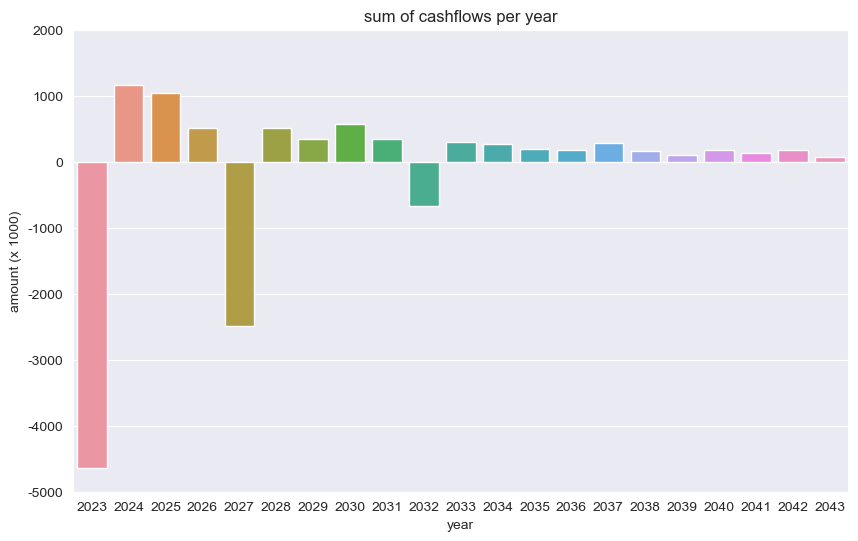

In [23]:
bankmodel.plot_cashflows()

### npv calculation

$$NPV = {{Cashflow} \over (1+i)^T}.$$
$$DF_0^T = [1+R_{zc}]^{-T})$$
where:
- $DF_0^T$  = a discount factor with maturity T
- $R_{zc}$ = A zero coupon interest rate
- $T$ = Maturity of the zero rate, in years (calculated as days/365)

In [26]:
result = bankmodel.calculate_npv(zerocurve, bankmodel.df_cashflows, bankmodel.pos_date)
print (f"npv = {sum(result['npv']):,.0f}")

npv = -1,877,139


In [27]:
r1 = bankmodel.calculate_risk(zerocurve,200,'Parallel')
print (f"r1 = {r1:,.0f}")

r1 = -353,733


### SOT (Supervisor Outlier Test)

In [29]:
bankmodel.step()
zerocurve.step()
result = bankmodel.calculate_npv(zerocurve,bankmodel.df_cashflows, bankmodel.pos_date)
print (f"npv = {sum(result['npv']):,.0f}")
r1 = bankmodel.calculate_risk(zerocurve,200,'Parallel')
print (f"r1 = {r1:,.0f}")

2023-04-17 21:08:54.410 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-04 00:00:00.


npv = -1,880,346
r1 = -353,482


### Calculate BPV

Risk paramters include BPV (Base Point Value), also called DV01 (Dollar value of 1).
This is the potential change in the EvE (Economic value of Equity), if we see a 1 bp (basispoint) shift in the zero curve.

So we shift each point on the zero curve by one bp, and recalculate the NPV under each of these scenario's.
The NPV is then calculated by sutracting the NPV under the base scenario from the NPV under the shifted scenario.

In [30]:
bpv = bankmodel.calculate_bpv(zerocurve)

<Figure size 1000x600 with 0 Axes>

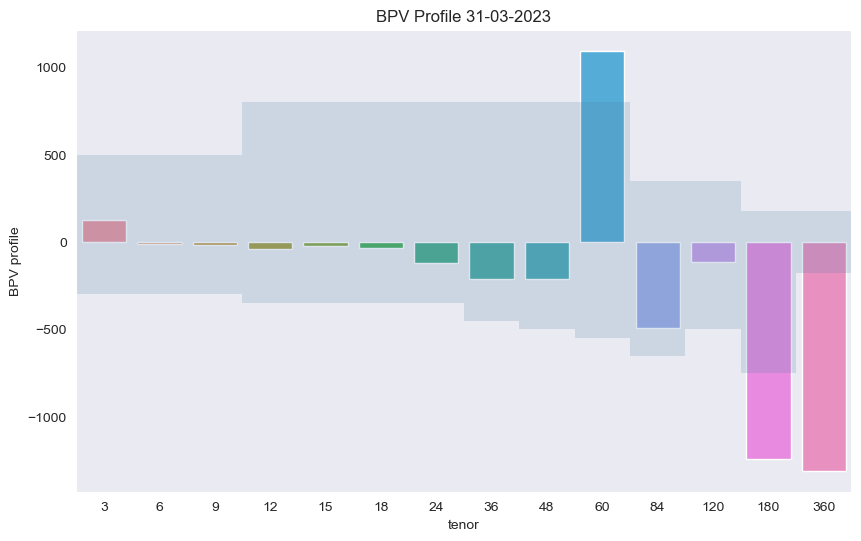

In [31]:
from src.data.definitions import DATA_RAW
from src.visualization import visualize
from pathlib import Path
limits = pd.read_excel(Path(DATA_RAW,'limits.xlsx'))
visualize.bpvplot(bpv, limits, title = f'BPV Profile {pos_date:%d-%m-%Y}');

In [32]:
bankmodel.clear_swap_contracts()

In [33]:
bankmodel.generate_swap_contract('buy', 132, zerocurve, amount = 25000000)

2023-04-17 21:09:08.799 | INFO     | src.models.bank_model:generate_swap_contract:266 - Added 1 swap contracts to our portfolio. 1 swaps in total.


In [35]:
result = bankmodel.calculate_npv(zerocurve, bankmodel.df_cashflows, bankmodel.pos_date)
print (f"npv = {sum(result['npv']):,.0f}")
# zerocurve.df.to_excel('zerocurve.xlsx')

npv = -1,880,350


In [36]:
bankmodel.generate_swap_contract('sell',120, zerocurve, amount = 2800000)
bankmodel.generate_swap_contract('sell',60, zerocurve, amount = 40000000)
bankmodel.generate_swap_contract('buy',48, zerocurve, amount = 40000000)

2023-04-17 21:09:26.963 | INFO     | src.models.bank_model:generate_swap_contract:266 - Added 1 swap contracts to our portfolio. 2 swaps in total.
2023-04-17 21:09:27.034 | INFO     | src.models.bank_model:generate_swap_contract:266 - Added 1 swap contracts to our portfolio. 3 swaps in total.
2023-04-17 21:09:27.107 | INFO     | src.models.bank_model:generate_swap_contract:266 - Added 1 swap contracts to our portfolio. 4 swaps in total.


<Figure size 1000x600 with 0 Axes>

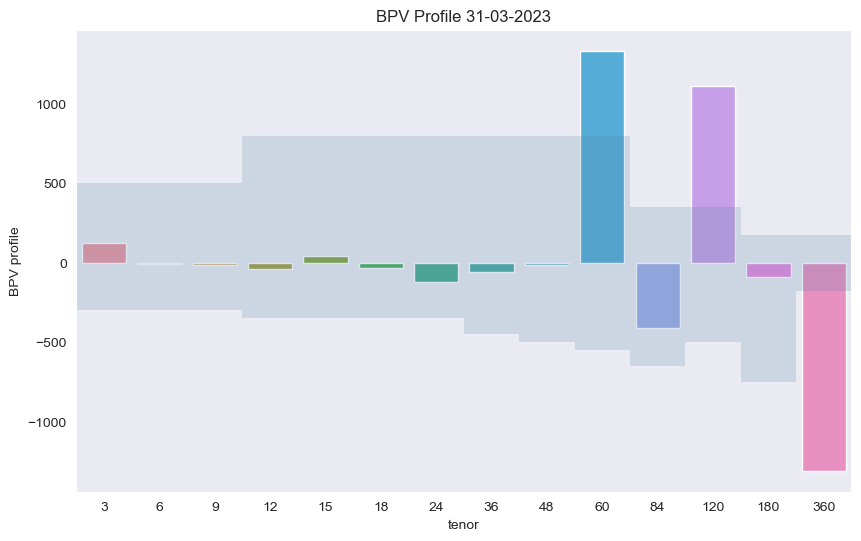

In [37]:
bpv = bankmodel.calculate_bpv(zerocurve)
from src.data.definitions import DATA_RAW
from src.visualization import visualize
from pathlib import Path
limits = pd.read_excel(Path(DATA_RAW,'limits.xlsx'))
visualize.bpvplot(bpv, limits, title = f'BPV Profile {pos_date:%d-%m-%Y}');

In [39]:
result = bankmodel.calculate_npv(zerocurve, bankmodel.df_cashflows, bankmodel.pos_date)
print (f"npv = {sum(result['npv']):,.0f}")

npv = -1,880,356


# Running an episode

Running an episode means we run through one possible trajectory of the bank - in the simualted environment.
Offcourse now this is still without any steering.

We use monte carlo simulation to step through a number of timesteps, and see the results in return and risk the bank is exposed to.
In order to generate the scenario's for monte carlo simulation it is necesarry to tackle the challange of correlated variables in Monte Carlo simulations.
Because in practice there is a strong correlation to these environmental factors. If we ignore this - the simulation would be made on unrealistic - unfeasible situations.
There are several ways to do this.

Multivariate distrubtion. 
Copulas may help if the correlation. But there is a simpler way. We can rely on historical simulation were we take growth rate sampled from the history. It is just important that we take the same sample date for each of the simulated variables.  That sounds very easy, and would work - if we have all factors for the same dates!

There are several alternatives for creating simuation of the Zero Curves. Which take into account multiple correlation, and the specific dynamics assosiated with yield curve construction. In furter research we could analyze if this would make any difference.
- Box-Muller Method
- Iman-Conover Method
- Vasicek factor 2 model
- Georgian Brown Movements, with cholesky decomposition
- Copulas (?)

2023-04-17 21:10:03.209 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-05 00:00:00.
2023-04-17 21:10:03.222 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-06 00:00:00.
2023-04-17 21:10:03.237 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-07 00:00:00.
2023-04-17 21:10:03.256 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-10 00:00:00.
2023-04-17 21:10:03.270 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-11 00:00:00.
2023-04-17 21:10:03.283 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-12 00:00:00.
2023-04-17 21:10:03.299 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-13 00:00:00.
2023-04-17 21:10:03.321 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-14 00:00:00.
2023-04-17 21:10:03.339 | DEBUG    | src.data.zerocurve:step:123 - Stepping in zerocurve 2023-04-17 00:00:00.
2023-04-17

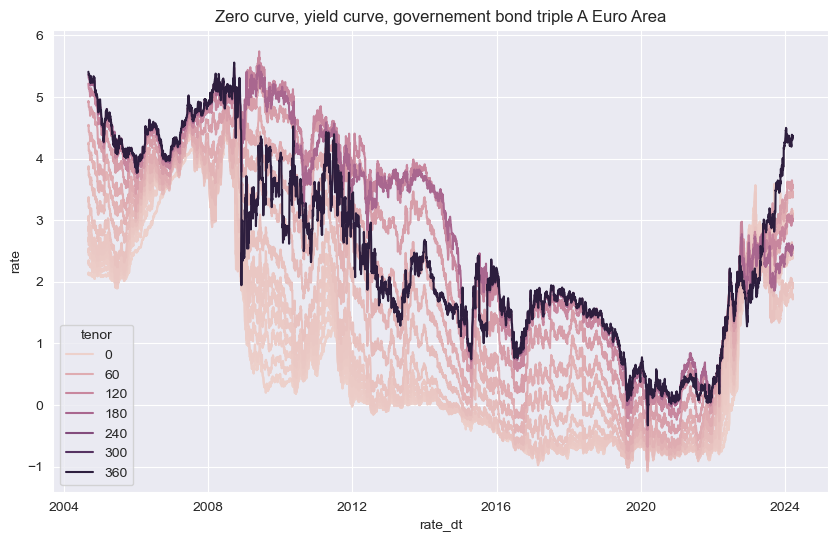

In [40]:
# run an episode of 100 steps

for i in range(252):
#    bankmodel.step()
    zerocurve.step()
#    risk.append(bankmodel.calculate_risk(zerocurve,200,'Parallel'))    
zerocurve.lineplot()

At the end of the episode we need to reset the bank to the original situation.

In [41]:
bankmodel.reset()
zerocurve.reset()

Buy or Sell Swaps to steer the interest profile

In [42]:
# Buy Fixed 30 year / sell swap Float 6M 
# Example deal 5390831 25 mln
# Pay interest Annual Swaprate 20y = 2.3 contract rate 3.059 fixed (aprox -764,750 p.a.)
# Rec Semi Annual 6M EURIBOR (aprox 249.636 s.a.)

bankmodel.generate_swap_contract('Sell',120, zerocurve, amount = 100000)
bankmodel.generate_swap_contract('Sell',360, zerocurve, amount = 100000)
bankmodel.generate_swap_contract('Sell',12, zerocurve, amount = 100000)
bankmodel.df_swaps


2023-04-17 21:10:32.216 | INFO     | src.models.bank_model:generate_swap_contract:266 - Added 1 swap contracts to our portfolio. 5 swaps in total.
2023-04-17 21:10:32.315 | INFO     | src.models.bank_model:generate_swap_contract:266 - Added 1 swap contracts to our portfolio. 6 swaps in total.
2023-04-17 21:10:32.375 | INFO     | src.models.bank_model:generate_swap_contract:266 - Added 1 swap contracts to our portfolio. 7 swaps in total.


,contract_no,pay,start_date,pay_freq,rec,rec_freq,principal,tenor,base_rate,margin
0,10001,fixed,2023-04-04,annual,float,semi annual,25000000,132,2.43,0
0,10002,float,2023-04-04,semi annual,fixed,annual,2800000,120,2.42,0
0,10003,float,2023-04-04,semi annual,fixed,annual,40000000,60,2.36,0
0,10004,fixed,2023-04-04,annual,float,semi annual,40000000,48,2.38,0
0,10005,float,2023-03-31,semi annual,fixed,annual,100000,120,2.41,0
0,10006,float,2023-03-31,semi annual,fixed,annual,100000,360,2.37,0
0,10007,float,2023-03-31,semi annual,fixed,annual,100000,12,2.78,0
